In [4]:
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
plt.rcParams['font.size']=14

In [5]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [6]:
# low resolution run C2
dss = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_20layerswdTdy_u01tw_withoutGM/state', 2, 3, 0)
dsg = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_20layerswdTdy_u01tw_withoutGM/grid', 2, 3, None)
dslr=xr.merge((dss,dsg))
dslr=dslr.isel(Zp1=slice(0,-1))
dslr['Z']=-1*dslr.Z
dslr['Zl']=-1*dslr.Zl
dslr=dslr.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dslr=xgcm.generate_grid_ds(dslr, {'X':'X', 'Y':'Y', 'Z':'Z'})
dslr.coords['day']=dslr.T/(24*3600)
dslr.coords['month']=dslr.day/30

# high res run C2
dss = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_dx5km_20layerswdTdy_u01tw_withoutGM/state', 10, 15, 0)
dsg = open_mncdataset('/home/birte/MITgcm_taylorcap/TC_runs/run_bump5000_dx5km_20layerswdTdy_u01tw_withoutGM/grid', 10, 15, None)
dshr=xr.merge((dss,dsg))
dshr=dshr.isel(Zp1=slice(0,-1))
dshr['Z']=-1*dshr.Z
dshr['Zl']=-1*dshr.Zl
dshr=dshr.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dshr=xgcm.generate_grid_ds(dshr, {'X':'X', 'Y':'Y', 'Z':'Z'})
dshr.coords['day']=dshr.T/(24*3600)
dshr.coords['month']=dshr.day/30

In [7]:
dshr['drU']=dshr.U.isel(T=0)*0+dshr.drF.isel(X=30,Y=20)
dshr['drV']=dshr.V.isel(T=0)*0+dshr.drF.isel(X=30,Y=20)
metrics = {
    ('X',): ['dxC', 'dxG', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF', 'drU', 'drV'], # Z distances
    }
grid = xgcm.Grid(dshr, periodic=False, metrics=metrics)

# Initial stratficiation

<ipython-input-15-ede6b029fb01>:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


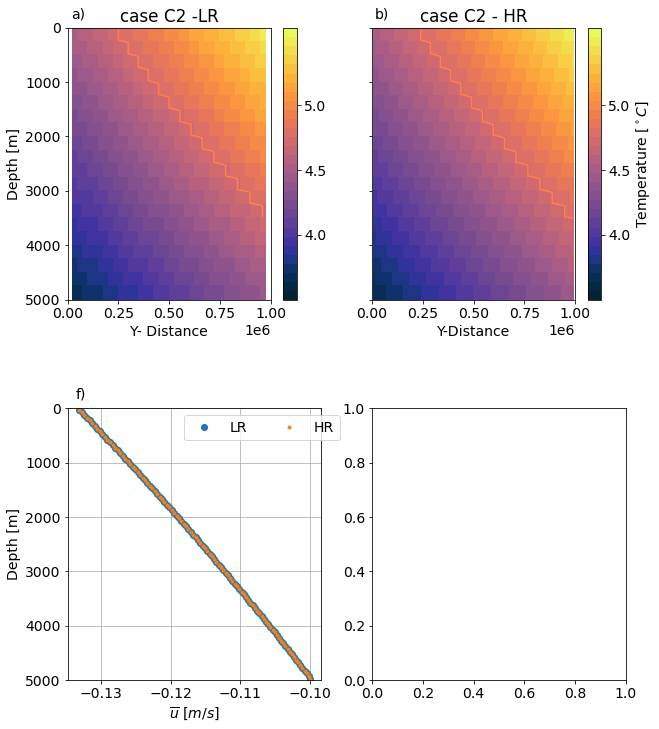

In [15]:

fig,axes=plt.subplots(2,2, figsize=(10,12),gridspec_kw={'width_ratios':[1,1],'hspace':.4})

ax0 = axes[0,0]
ax1 = axes[0,1]

ax4 = axes[1,0]


# Plot used bathymetries

# Plot used temperature stratification
dslr.Temp.where(dslr.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=3.5,vmax=5.6,levels=31,cmap=cmo.thermal,ax=ax0,cbar_kwargs={'label':'','ticks':np.linspace(4,5,3)})#,add_colorbar=False)ax=ax4)#,add_colorbar=False)
dslr.Temp.where(dslr.Temp>0).isel(X=10,T=0).plot.contour(ax=ax0,colors=['coral'],levels=[4.75])

dshr.Temp.where(dshr.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=3.5,vmax=5.6,levels=31,ax=ax1,cmap=cmo.thermal,cbar_kwargs={'label':'Temperature [$^\circ C$]','ticks':np.linspace(4,5,3)})#,add_colorbar=False)
dshr.Temp.where(dshr.Temp>0).isel(X=10,T=0).plot.contour(levels=[4.75],ax=ax1,colors=['coral'])

# velocity profiles
(dslr.U.where(dslr.U!=0).isel(X_left=59,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label='LR',ls='',marker='o')
(dshr.U.where(dshr.U!=0).isel(X_left=299,T=0).mean(dim='Y')).plot(y="Z",ax=ax4,label='HR',ls='',marker='.')
ax4.grid()
ax4.set_xlabel('$\overline{u}$ [$m/s$]')
ax4.set_ylabel('Depth [m]')
ax4.set_ylim(5000,0)
ax4.legend(bbox_to_anchor=[1.1,1], ncol=2)
ax4.set_title('')

ax0.set_xlabel('Y- Distance')
ax0.set_ylabel('Depth [m]')
ax0.set_title('case C2 -LR')


ax1.set_xlabel('Y-Distance')
ax1.set_ylabel('')
ax1.set_yticklabels('')
ax1.set_title('case C2 - HR')

ax0.invert_yaxis()
ax1.invert_yaxis()



ax0.text(0.05, 1.05, 'a)', horizontalalignment='center',verticalalignment='center', transform=ax0.transAxes)
ax1.text(0.05, 1.05, 'b)', horizontalalignment='center',verticalalignment='center', transform=ax1.transAxes)
ax2.text(0.05, 1.05, 'c)', horizontalalignment='center',verticalalignment='center', transform=ax2.transAxes)
ax3.text(0.05, 1.05, 'd)', horizontalalignment='center',verticalalignment='center', transform=ax3.transAxes)
ax31.text(0.05, 1.05,'e)', horizontalalignment='center',verticalalignment='center', transform=ax31.transAxes)
ax4.text(0.05, 1.05, 'f)', horizontalalignment='center',verticalalignment='center', transform=ax4.transAxes)

plt.tight_layout()


#plt.savefig('./figures/temp_uvel_setup_new_withoutGM.jpg',dpi=300)

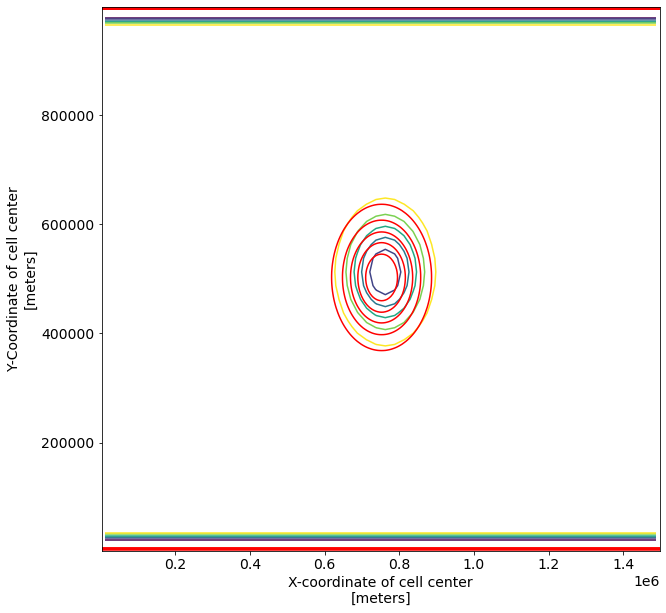

In [23]:
plt.figure(figsize=(10,10))
dslr.Depth.plot.contour(levels=[4500,4000,3500,3000,2500,2000])
dshr.Depth.plot.contour(levels=[4500,4000,3500,3000,2500,2000], colors='r')

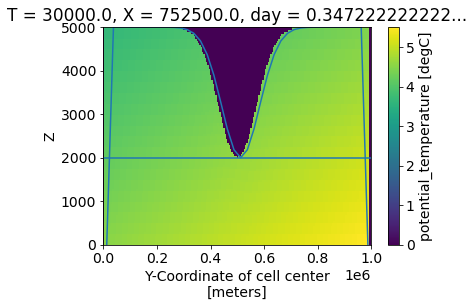

In [33]:
dslr.Depth.isel(X=30).plot()
dshr.Temp.isel(T=1, X=150).plot.pcolormesh()
plt.hlines(2000,0,1e6)